<a href="https://colab.research.google.com/github/medrante/spectral_project/blob/main/spectral_project_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Project (Thesis)

## Outline
- Install libraries
- Set variables
- Create telescope aperture
- Helper functions
  - Create first / main wavefront
  - Propagate main wavefront
  - Create other wavefronts
  - Propagate them
  - Generate power spectrum
- Save all the images

- All the resnets

## Install and import Libraries

If you are running this notebook on Colab, you can run the following cell to install the libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

# TODO: When Colab can install gala, switch from astro-gala

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install hcipy asdf==2.14.0 #torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, ceil, cos, sin

In [3]:
# https://github.com/medrante/spectral_project/blob/main/color_magnitude_table.csv


url = 'https://raw.githubusercontent.com/medrante/spectral_project/main/color_magnitude_table.csv'
df = pd.read_csv(url,index_col=0)

df.columns

Index(['mag_s_v', 'color_s_v', 'mag_u_v', 'color_u_v', 'mag_b_v', 'color_b_v',
       'mag_V', 'color_V', 'mag_v_w', 'color_v_w', 'mag_v_x', 'color_v_x',
       'mag_v_p', 'color_v_p', 'mag_v_z', 'color_v_z'],
      dtype='object')

In [4]:
s_wlen = df['color_V'] + df['color_s_v']
s_mag = df['mag_s_v']

In [5]:
# s_wlen, s_mag

## Helper Functions

### Create Bright Object

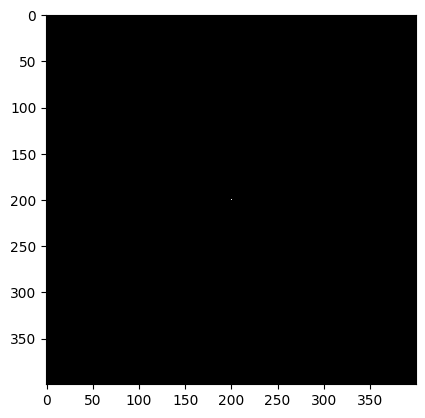

In [6]:
focal_plane = 400

# 1. create image of size 400 pixels
B = np.zeros([focal_plane]*2, dtype = 'float')
# plt.imshow(B, cmap='gray')

# 2. Add the bright object
mid = int(focal_plane/2)
B[mid, mid] = 1
plt.imshow(B, cmap='gray')

### Create offset object

In [7]:
def create_offset_object(B_obj, theta, s):

  # size = 2000
  # is_cso_present = np.random.randint(0, 2, size)  # random generator for True and False, size 1K
  # theta = np.random.uniform(-pi,pi) # orientation
  # s =  np.random.uniform(0,200)# separation in m

  # instantaneous fov = full fov / # of pixels
  fov = 61.9
  v = fov / focal_plane
  # v =  61.9 # IFOV
  b =  3.5786e7 # distance to orbit
  den = (v*b*pi)/(180*3600) # meters per pixel
  delta_m = np.random.uniform(0,7)


  # for i, cso in enumerate(is_cso_present):
      # if cso:
  x = ((s/den)*cos(theta))
  y = ((s/den)*sin(theta))
  cso_val = pow(10, (-0.4*abs(delta_m)))
  print(v, den, cso_val)

  offset_x = mid+int(x)
  offset_y = mid+int(y)
  B[offset_x, offset_y] = cso_val

  # is_cso_present[0:100]

  # plot B
  plt.imshow(B, cmap='gray')
  plt.title(f'{offset_x}, {offset_y}')
  # offset_x, offset_y, cso_val, theta
  return B

0.15475 26.84841685190761 0.006144347885712976


(-0.7123034886592472, 150.49452001729284)

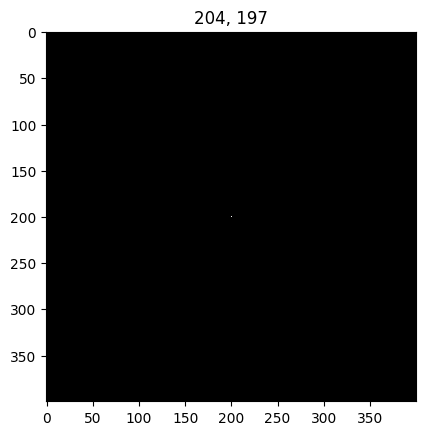

In [8]:
theta = np.random.uniform(-pi,pi) # orientation
s =  np.random.uniform(0,200)# separation in m

create_offset_object(B, theta, s)
theta, s

### Create telescope aperture and wavefront

The telescope diameter is 3.6m. The grid will be 400 x 400.

I used these as reference. It seems like Ian Cunnyngham worked with AMOS on another project and has had experience with hcipy

https://github.com/icunnyngham/TelescopeSim/blob/main/telescope_sim/multi_aperture_psf.py#L285

https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-03-Construction-of-an-artificial-but-realistic-image.html

In [9]:
from hcipy import *
import scipy.special as ss
from scipy import ndimage
from scipy.signal import fftconvolve
import scipy.fft as fft

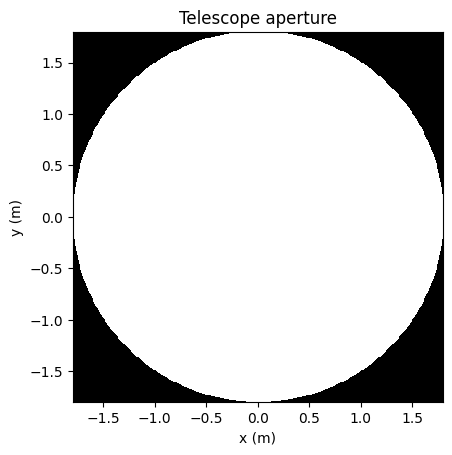

In [31]:
telescope_diameter = 3.6
focal_length = 726

# the emccd is technically 512 x 512,
# to convert to 400 x 400, have to undersize by 25/32
# so 512 * 25 / 32 = 400
undersizing_factor = 25/32
num_pupil_pixels = 512 * undersizing_factor
pupil_grid_diameter = telescope_diameter * undersizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, telescope_diameter)
# pupil grid should be 400 x 400 now

aperture = make_circular_aperture(telescope_diameter)(pupil_grid)

# plot the telescope aperture
im = imshow_field(aperture, cmap='gray')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Telescope aperture')
plt.show()


### Propagate wavefront

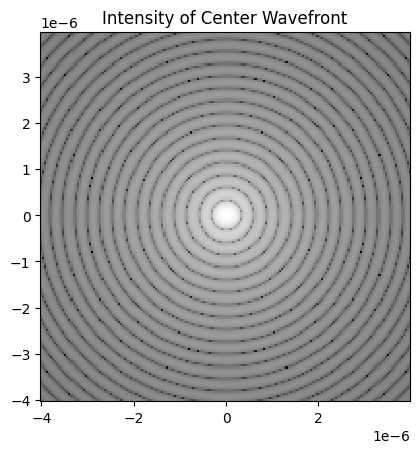

In [78]:
# Creating the wavefront and propagating it through the telescope

# fov =  61.9 # fov of the VisIm
# fov = 10
# m_per_pix = fov*np.pi/(180*3600)
# focal_grid = make_uniform_grid([focal_plane]*2, fov)


wlen = 966e-9
wf = Wavefront(aperture, wlen)

# use this
# https://docs.hcipy.org/dev/tutorials/SimplePolarimeter/SimplePolarimeter.html

spatial_resolution_telescope = wlen / telescope_diameter
focal_grid = make_focal_grid(q=6, num_airy=15, spatial_resolution=spatial_resolution_telescope)
#We use here 4 pixels per resolution elements and set the field of view to 60 lambda/D in radius at the science wavelength

# https://www.ita.uni-heidelberg.de/~dullemond/lectures/obsastro_2010/Chapter_Diffraction.pdf
# this paper explains diffraction


prop = FraunhoferPropagator(pupil_grid, focal_grid)

# prop = Propagator()
img = prop.forward(wf)

# imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5,cmap='gray')
# plt.title('Focal Grid of Center Wavefront')
# plt.show()

imshow_field(np.log10(img.intensity / img.intensity.max()), cmap='gray')
plt.title('Intensity of Center Wavefront')
plt.show()

<ipython-input-79-7725d8281d5a>:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(B_conv), vmin=-5, cmap ='gray')
<ipython-input-79-7725d8281d5a>:5: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(B_conv), vmin=-5, cmap ='gray')


Text(0.5, 1.0, 'Original Image convolved with Airy Disc')

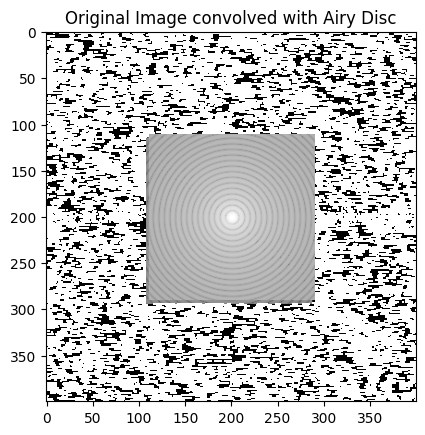

In [79]:
psf = img.intensity.shaped

B_conv = fftconvolve(B, psf, mode='same')

plt.imshow(np.log(B_conv), vmin=-5, cmap ='gray')
plt.title('Original Image convolved with Airy Disc')
# https://apps.dtic.mil/sti/pdfs/ADA616793.pdf
# use this as reference

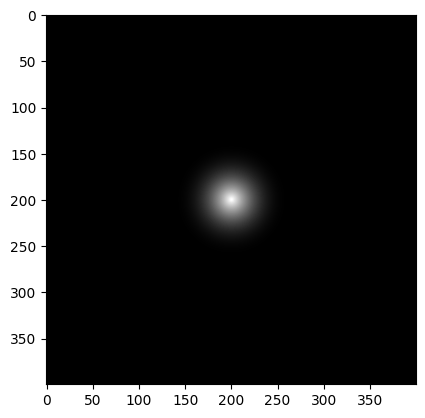

In [80]:
# create power spectrum
# ref:    https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=2776&context=theses

fourier_image = np.fft.fftshift(np.fft.fft2(B_conv))

PS = (np.abs(fourier_image))**2
plt.imshow(PS, cmap='gray')

In [77]:
# # for noisy detector
# # https://docs.hcipy.org/0.5.1/getting_started/2_wavefronts_optical_systems.html?highlight=detector
# dark = 22   # for VisIm - from Roberts paper
# rms = 12    # read noise
# detector = NoisyDetector(focal_grid, dark_current_rate=dark, read_noise=rms)
# # detector.integrate(img, 0.5)
# # image = detector.read_out()


# aberration = SurfaceAberration(pupil_grid, 0.25, 1)

# wf = Wavefront(aperture)
# img = prop(aberration(wf))

# wf.total_power = 5000

# # imshow_field(np.log10(img.intensity / img.intensity.max()))
# # plt.colorbar()
# # plt.show()

detector.integrate(img, 0.5)
image = detector.read_out()

imshow_field(np.log10(image), vmax=np.log10(image).max(), cmap='gray')
plt.colorbar()
plt.show()

ValueError: cannot reshape array of size 32400 into shape (720,1,720,1)

In [ ]:


# Algorithm Step #10
# Applying noise and atmostpheric turbulence to the power spectrum
# integration times of 100msec = 100e-3 s
# atmospheric decorrelation time of 1 sec
# The mean and standard deviation of these averaged calibration frames were determined to capture stochastically due to atmosphere

# Then, compute total photon counts present in each object.
# Spectral Flux Density (W/m^2/m) is calculated from the center of the sensor
# filter bandwidth and coverted to photon fluck density (photons/sec/m^2/m)
# Photon count N = product of the integration time t (sec), sensor filter
# bandwidth w(m), aperture area A (m^2), quantum efficiency q, photon flux
# density p, and brightness ratio of object m;

# assume q = 0.8 - from the notes section of paper

t = 100e-3
q = 0.8
# m = np.random.uniform(10,18)

N = 10**(-0.4*m)*A*w*p*q*t


## Generation all the images